In [1]:
import os 
os.environ['http_proxy'] = 'http://proxy-ws.cbank.kz:8080'
os.environ['https_proxy'] = 'http://proxy-ws.cbank.kz:8080'

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import random
import matplotlib.pyplot as plt
from datasets import load_dataset
import re
from collections import Counter
import time

In [123]:
dataset = load_dataset('imdb')

train_data = dataset['train']
test_data  = dataset['test']


In [124]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9'\s]", '', text)
    tokens = text.split()
    return tokens

tokens = []
for item in train_data:
    tokens.extend(tokenize(item['text']))

vocab_size = 10000
counts = Counter(tokens)
vocab = sorted(counts, key=counts.get, reverse=True)[:vocab_size-2] 

word2idx = {'<PAD>': 0, '<UNK>': 1}
for i, w in enumerate(vocab, start=2):
    word2idx[w] = i

idx2word = {v: k for k, v in word2idx.items()}

def text_to_sequence(text, word2idx, max_length=200):
    tokens = tokenize(text)
    seq = []
    for t in tokens:
        seq.append(word2idx[t] if t in word2idx else word2idx['<UNK>'])

    seq = seq[:max_length]
    seq += [word2idx['<PAD>']] * (max_length - len(seq))
    return seq


In [125]:
class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, max_length=200):
        self.data = dataset
        self.word2idx = word2idx
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        
        seq = text_to_sequence(text, self.word2idx, self.max_length)
        seq = torch.tensor(seq, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        
        return seq, label

max_length = 200
train_dataset = IMDBDataset(train_data, word2idx, max_length=max_length)
test_dataset  = IMDBDataset(test_data,  word2idx, max_length=max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [126]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        embedded = self.embedding(x)  
        output, hidden = self.rnn(embedded)  
        last_hidden = hidden[-1]
        
        logits = self.fc(last_hidden)  
        return logits


In [127]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, ff_dim=512, num_layers=2, max_length=200, pad_idx=0, num_classes=2):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pos_emb = nn.Embedding(max_length, embed_dim)
        layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_emb(x) + self.pos_emb(positions)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)

In [128]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        losses = 0.0
        correct = 0
        total = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            
            
            optimizer.step()
            
            losses += loss.item() * sequences.size(0)
            
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        epoch_train_loss = losses / len(train_loader.dataset)
        epoch_train_acc = correct / total
        
        #testing
        model.eval()
        losses_test = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                losses_test += loss.item() * sequences.size(0)
                
                _, predicted = torch.max(outputs, dim=1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
        
        epoch_test_loss = losses_test / len(test_loader.dataset)
        epoch_test_acc = correct_test / total_test
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] " 
              f"Train Loss: {epoch_train_loss:.5f} Train Acc: {epoch_train_acc:.5f} "
              f"Test Loss: {epoch_test_loss:.5f} Test Acc: {epoch_test_acc:.5f}")
    
    end_time = time.time()
    total_time = end_time - start_time  
    return train_losses, test_losses, train_accuracies, test_accuracies, total_time


In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [130]:
model = RNN(vocab_size=vocab_size, embed_dim=128, hidden_size=128, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
train_losses, test_losses, train_acc, test_acc, train_time = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device
)


Epoch [1/10] Train Loss: 0.69735 Train Acc: 0.50212 Test Loss: 0.69373 Test Acc: 0.50452
Epoch [2/10] Train Loss: 0.69577 Train Acc: 0.51808 Test Loss: 0.70178 Test Acc: 0.49952
Epoch [3/10] Train Loss: 0.68796 Train Acc: 0.53576 Test Loss: 0.70417 Test Acc: 0.53316
Epoch [4/10] Train Loss: 0.67279 Train Acc: 0.56800 Test Loss: 0.70079 Test Acc: 0.50096
Epoch [5/10] Train Loss: 0.66861 Train Acc: 0.56744 Test Loss: 0.71602 Test Acc: 0.52148
Epoch [6/10] Train Loss: 0.65283 Train Acc: 0.57920 Test Loss: 0.72086 Test Acc: 0.52168
Epoch [7/10] Train Loss: 0.63234 Train Acc: 0.59752 Test Loss: 0.74774 Test Acc: 0.51620
Epoch [8/10] Train Loss: 0.60774 Train Acc: 0.61716 Test Loss: 0.75836 Test Acc: 0.52548
Epoch [9/10] Train Loss: 0.61525 Train Acc: 0.61136 Test Loss: 0.71357 Test Acc: 0.50736
Epoch [10/10] Train Loss: 0.65584 Train Acc: 0.56708 Test Loss: 0.71920 Test Acc: 0.50432


In [131]:
model = TransformerClassifier(vocab_size=len(word2idx), pad_idx=word2idx['<PAD>'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses_t, test_losses_t, train_accs_t, test_accs_t, train_time_t = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device
)

Epoch [1/10] Train Loss: 0.48544 Train Acc: 0.75208 Test Loss: 0.38470 Test Acc: 0.82456
Epoch [2/10] Train Loss: 0.32696 Train Acc: 0.85820 Test Loss: 0.39143 Test Acc: 0.82404
Epoch [3/10] Train Loss: 0.28755 Train Acc: 0.87828 Test Loss: 0.40655 Test Acc: 0.82616
Epoch [4/10] Train Loss: 0.25569 Train Acc: 0.89452 Test Loss: 0.39624 Test Acc: 0.83524
Epoch [5/10] Train Loss: 0.30382 Train Acc: 0.86600 Test Loss: 0.48725 Test Acc: 0.78708
Epoch [6/10] Train Loss: 0.38335 Train Acc: 0.82736 Test Loss: 0.49175 Test Acc: 0.76572
Epoch [7/10] Train Loss: 0.44074 Train Acc: 0.79052 Test Loss: 0.54462 Test Acc: 0.73248
Epoch [8/10] Train Loss: 0.49171 Train Acc: 0.76040 Test Loss: 0.56840 Test Acc: 0.71160
Epoch [9/10] Train Loss: 0.52609 Train Acc: 0.73576 Test Loss: 0.58900 Test Acc: 0.69116
Epoch [10/10] Train Loss: 0.53485 Train Acc: 0.72756 Test Loss: 0.59031 Test Acc: 0.68884


In [132]:
print(train_time, train_time_t)

43.62420129776001 61.11458992958069


# Task 2

Attention Weights:
 [[0.374 0.114 0.337 0.175]
 [0.301 0.182 0.296 0.221]
 [0.345 0.135 0.328 0.192]
 [0.314 0.166 0.304 0.216]]


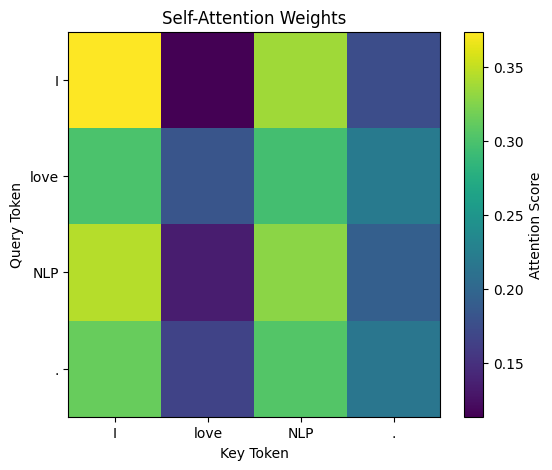

In [23]:
import numpy as np
import matplotlib.pyplot as plt

tokens = ["I", "love", "NLP", "."]

d_model = 4
np.random.seed(42)

embeddings = np.random.rand(len(tokens), d_model)

W_q = np.random.rand(d_model, d_model)
W_k = np.random.rand(d_model, d_model)
W_v = np.random.rand(d_model, d_model)

Q = embeddings @ W_q
K = embeddings @ W_k
V = embeddings @ W_v

d_k = d_model
scores = (Q @ K.T) / np.sqrt(d_k)

exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
attention_weights = exp_scores / exp_scores.sum(axis=1, keepdims=True)

attention_output = attention_weights @ V

print("Attention Weights:\n", np.round(attention_weights, 3))

plt.figure(figsize=(6, 5))
plt.imshow(attention_weights, aspect='auto')
plt.colorbar(label='Attention Score')
plt.xticks(range(len(tokens)), tokens)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel("Key Token")
plt.ylabel("Query Token")
plt.title("Self-Attention Weights")
plt.show()


# Task 3

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math  

# 1. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :].to(x.device)


In [135]:
# 2. Scaled Dot-Product Attention
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        # Q,K,V: (batch_size, heads, seq_len, d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(Q.size(-1))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        return torch.matmul(attn, V), attn

In [136]:
# 3. Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.attn = ScaledDotProductAttention(dropout)
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        bsz, seq_len, _ = x.size()
        # project and split heads
        Q = self.W_q(x).view(bsz, seq_len, self.num_heads, self.d_k).transpose(1,2)
        K = self.W_k(x).view(bsz, seq_len, self.num_heads, self.d_k).transpose(1,2)
        V = self.W_v(x).view(bsz, seq_len, self.num_heads, self.d_k).transpose(1,2)

        out, _ = self.attn(Q, K, V, mask)                     # (bsz, heads, seq_len, d_k)
        out = out.transpose(1,2).contiguous().view(bsz, seq_len, -1)
        out = self.dropout(self.fc_out(out))
        # residual + norm
        return self.norm(x + out)

In [137]:
# 4. Position-wise Feed-Forward
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        return self.norm(x + self.net(x))

In [138]:
# 5. Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)

    def forward(self, x, mask=None):
        x = self.self_attn(x, mask)
        x = self.ff(x)
        return x

In [139]:
# 6. Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [140]:
# 7. Full Classifier
class TransformerClassifierFromScratch(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, ff_dim=512,
                 num_layers=2, max_length=200, pad_idx=0, num_classes=2, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pos_enc   = PositionalEncoding(embed_dim, max_length)
        self.encoder   = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        self.fc_out    = nn.Linear(embed_dim, num_classes)

    def forward(self, x, mask=None):
        # x: (bsz, seq_len)
        x = self.token_emb(x)              # (bsz, seq_len, embed_dim)
        x = self.pos_enc(x)
        x = self.encoder(x, mask)          # (bsz, seq_len, embed_dim)
        x = x.mean(dim=1)                  # global average pooling
        return self.fc_out(x)


In [141]:
# === Usage ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifierFromScratch(
    vocab_size=len(word2idx),
    pad_idx=word2idx['<PAD>']
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer,
    num_epochs=5, device=device
)

print(f"Final Val Accuracy: {val_accs[-1]:.4f}, Loss: {val_losses[-1]:.4f}")


Epoch [1/5] Train Loss: 0.51735 Train Acc: 0.73336 Test Loss: 0.47982 Test Acc: 0.76552
Epoch [2/5] Train Loss: 0.35205 Train Acc: 0.84584 Test Loss: 0.45263 Test Acc: 0.78916
Epoch [3/5] Train Loss: 0.28363 Train Acc: 0.88244 Test Loss: 0.35793 Test Acc: 0.84552
Epoch [4/5] Train Loss: 0.23372 Train Acc: 0.90484 Test Loss: 0.37917 Test Acc: 0.84332
Epoch [5/5] Train Loss: 0.19301 Train Acc: 0.92560 Test Loss: 0.41793 Test Acc: 0.83932


ValueError: too many values to unpack (expected 4)

# Task 4

In [14]:
from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
metric = evaluate.load("accuracy")

# 1. Load and prepare data
raw_datasets = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

tokenized = raw_datasets.map(tokenize_batch, batched=True)
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch", columns=["input_ids","attention_mask","labels"])

# 2. Model & Trainer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./bert-imdb",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    save_total_limit=1,
    logging_steps=100,
)

# metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return metric.compute(predictions=preds, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
)

# 3. Train & Evaluate
trainer.train()
results = trainer.evaluate()
print("BERT IMDB accuracy:", results["eval_accuracy"])


/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the sam

Epoch,Training Loss,Validation Loss,Accuracy
1,0.311400,0.319850,0.900400
2,0.152800,0.343995,0.919800


BERT IMDB accuracy: 0.9198


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [15]:
from datasets import load_dataset

ds = load_dataset("tiny_shakespeare")
with open("shakespeare_train.txt", "w", encoding="utf-8") as f:
    for example in ds["train"]["text"]:
        f.write(example + "\n")


The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating test split: 100%|██████████| 1/1 [00:00<00:00, 1932.86 examples/s]


In [21]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)  # Move model to device

# Load dataset
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="shakespeare_train.txt",
    block_size=128
)

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-shakespeare",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    fp16=torch.cuda.is_available(),  
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./gpt2-shakespeare")
tokenizer.save_pretrained("./gpt2-shakespeare")

# Generate text
prompt = "To be or not to be"
inputs = tokenizer(prompt, return_tensors="pt").to(device)  # Move inputs to device
outputs = model.generate(
    **inputs,
    max_length=100,
    num_beams=5,
    no_repeat_ngram_size=2,
    early_stopping=True
)

# Decode and print the generated text
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss
100,4.026000
200,3.755400
300,3.668200
400,3.660200
500,3.633400
600,3.542100
700,3.377600
800,3.382300
900,3.375900
1000,3.386000


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


To be or not to be?

DUKE VINCENTIO:
I do not know, sir, but I know not what to say;
But, if you will, I'll tell you what you must
say; and I will not be so bold as to speak.
What is the matter, then, that you are to-day,
To-morrow, or next day, when you shall be come to
the city? What is your purpose,


In [24]:
import torch
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load dataset and models
raw = load_dataset("wmt16", "de-en", split="train[:1%]")
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)  # Move model to device

# 2. Preprocess for translation
def preprocess(batch):
    inputs = ["translate German to English: " + ex["de"] for ex in batch["translation"]]
    targets = [ex["en"] for ex in batch["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized = raw.map(preprocess, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# 3. Trainer setup
training_args = TrainingArguments(
    output_dir="./t5-wmt16",
    evaluation_strategy="no",
    per_device_train_batch_size=8,
    num_train_epochs=1,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),  # Enable mixed precision if GPU is available
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
)

# 4. Train the model
trainer.train()



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
500,1.227100
1000,0.647600
1500,0.630100
2000,0.613400
2500,0.595600
3000,0.598800
3500,0.595900
4000,0.589400
4500,0.579800
5000,0.577000


TrainOutput(global_step=5687, training_loss=0.6545496256925403, metrics={'train_runtime': 151.6267, 'train_samples_per_second': 300.007, 'train_steps_per_second': 37.507, 'total_flos': 1539140801789952.0, 'train_loss': 0.6545496256925403, 'epoch': 1.0})

In [47]:
# 5. Translation example
sample = "Hallo! Mein Name ist Alikhan, ich habe einen Bachelor-Abschluss an der KBTU"
inputs = tokenizer("translate German to English: " + sample, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}  
translated = model.generate(**inputs, max_length=60)
print("T5 translation:", tokenizer.decode(translated[0], skip_special_tokens=True))


T5 translation: Hallo, my name is Alikhan, I have a Bachelor' s degree in the KBTU.


In [41]:
# 6. Summarization example
summ_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)  # Move summarization model to device
text = """Abai walked across the steppe, his eyes fixed on the horizon where the earth and sky met. 
He stopped by a small stream and bent down to drink from it.
With each step, his thoughts became clearer, as he pondered life, people, and the meaning of existence. 
Soon, Abai took out a scroll and began to write. 
His pen glided across the paper, and words full of deep meaning formed into lines. 
He continued writing until evening, unaware of the sun sinking behind the horizon."""

inp = tokenizer(
    "summarize: " + text,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=128  # Increased to accommodate longer input
)

# Move inputs to device
inp = {k: v.to(device) for k, v in inp.items()}

# Generate summary with longer max_length
summary = summ_model.generate(
    **inp,
    max_length=50,  # Increased for longer summary
    num_beams=4,    # Beam search for better quality
    no_repeat_ngram_size=2,  # Prevent repetition
    early_stopping=True
)

# Decode and print the summary
print("T5 summary:", tokenizer.decode(summary[0], skip_special_tokens=True))

T5 summary: abai pondered life, people, and the meaning of existence. he continued writing until evening, unaware of the sun sinking behind the horizon.


# Task 5


In [1]:
import spacy
from spacy import displacy

nlp_sm = spacy.load("en_core_web_sm")

text = "My name is Alikhan Zhamankhan and currently I study at KBTU"

doc = nlp_sm(text)

print("spaCy NER Results (en_core_web_sm):")
for ent in doc.ents:
    print(f"{ent.text:<20} {ent.label_:<15}")

# Visualize the entities
displacy.render(doc, style="ent", jupyter=True)

spaCy NER Results (en_core_web_sm):
Alikhan Zhamankhan   PERSON         
KBTU                 ORG            


In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from datasets import load_dataset
import evaluate
import numpy as np

# Load dataset
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["ner_tags"].feature.names

# Preprocess function
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

/opt/conda/envs/classifier/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# Tokenize dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Load model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased", 
    num_labels=9,
    id2label={0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG", 
              5: "B-LOC", 6: "I-LOC", 7: "B-MISC", 8: "I-MISC"},
    label2id={"O": 0, "B-PER": 1, "I-PER": 2, "B-ORG": 3, "I-ORG": 4, 
              "B-LOC": 5, "I-LOC": 6, "B-MISC": 7, "I-MISC": 8}
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./ner_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="no",
    logging_dir='./logs',
)

# Metrics
seqeval = evaluate.load("seqeval")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [4]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

data_collator = DataCollatorForTokenClassification(tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



In [5]:
# Train the model
trainer.train()



wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alihan-zhamankhan (alihan-zhamankhan-kazakh-british-technical-university). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.163100,0.041844,0.922898,0.934702,0.928763,0.988474
2,0.027500,0.036939,0.943766,0.949007,0.946379,0.990888
3,0.014300,0.036835,0.941529,0.951195,0.946337,0.991083


TrainOutput(global_step=2634, training_loss=0.05211059234317904, metrics={'train_runtime': 84.1895, 'train_samples_per_second': 500.335, 'train_steps_per_second': 31.287, 'total_flos': 1050534559887048.0, 'train_loss': 0.05211059234317904, 'epoch': 3.0})

In [7]:
# Evaluate
eval_results = trainer.evaluate()
print("BERT NER Evaluation Results:")
print(f"Precision: {eval_results['eval_precision']:.3f}")
print(f"Recall: {eval_results['eval_recall']:.3f}")
print(f"F1 Score: {eval_results['eval_f1']:.3f}")
print(f"Accuracy: {eval_results['eval_accuracy']:.3f}")

# Inference with the fine-tuned model
from transformers import pipeline

ner_pipeline = pipeline(
    "ner", 
    model=model, 
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

sample_text = "Kaspi kz is looking buying Jusan for 1 billion dollars in 2024"
results = ner_pipeline(sample_text)

print("\nBERT NER Results:")
for entity in results:
    print(f"{entity['word']:<20} {entity['entity_group']:<15} {entity['score']:.2f}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


BERT NER Evaluation Results:
Precision: 0.942
Recall: 0.951
F1 Score: 0.946
Accuracy: 0.991

BERT NER Results:
Kaspi kz             ORG             0.98
Jusan                ORG             0.81


# Pos tagging

In [7]:
nlp_sm = spacy.load("en_core_web_sm")

# Sample text for POS tagging
pos_text = "Alikhan were running on marathon and tried to complete it"

# Process the text
doc =  nlp_sm(pos_text)

# Display POS tags and dependencies
print("spaCy POS Tagging Results (en_core_web_trf):")
print(f"{'Token':<15} {'POS':<10} {'Tag':<10} {'Dependency':<15}")
for token in doc:
    print(f"{token.text:<15} {token.pos_:<10} {token.tag_:<10} {token.dep_:<15}")

# Visualize the parse tree
displacy.render(doc, style="dep", jupyter=True)

spaCy POS Tagging Results (en_core_web_trf):
Token           POS        Tag        Dependency     
Alikhan         PROPN      NNP        nsubj          
were            AUX        VBD        aux            
running         VERB       VBG        ROOT           
on              ADP        IN         prep           
marathon        NOUN       NN         pobj           
and             CCONJ      CC         cc             
tried           VERB       VBD        conj           
to              PART       TO         aux            
complete        VERB       VB         xcomp          
it              PRON       PRP        dobj           


# pos tagging with transformers

In [8]:
from transformers import pipeline

# Load a pre-trained POS tagging model
pos_pipeline = pipeline(
    "token-classification", 
    model="vblagoje/bert-english-uncased-finetuned-pos",
    aggregation_strategy="simple"
)

# Sample text
pos_text = "Alikhan and Nur are master's students at KBTU"

# Get POS tags
pos_results = pos_pipeline(pos_text)

print("\nBERT POS Tagging Results:")
print(f"{'Token':<15} {'POS Tag':<10} {'Score':<10}")
for tag in pos_results:
    print(f"{tag['word']:<15} {tag['entity_group']:<10} {tag['score']:.2f}")

Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



BERT POS Tagging Results:
Token           POS Tag    Score     
alikhan         PROPN      1.00
and             CCONJ      1.00
nur             PROPN      1.00
are             AUX        1.00
master          NOUN       0.99
' s             PART       1.00
students        NOUN       1.00
at              ADP        1.00
kbtu            PROPN      0.97


# Comparison

In [9]:
# POS Tagging Comparison with proper token alignment
import pandas as pd
# Sample text for comparison
compare_text = "Nur won Halyk onai in 2024 and Alikhan won ICPC"

# spaCy POS tagging
doc_spacy_pos = nlp_sm(compare_text)
spacy_tokens = [token.text for token in doc_spacy_pos]
spacy_pos_tags = [token.pos_ for token in doc_spacy_pos]

# BERT POS tagging
bert_results = pos_pipeline(compare_text)
bert_tokens = [result['word'] for result in bert_results]
bert_pos_tags = [result['entity_group'] for result in bert_results]

# Create aligned DataFrame
pos_comparison = pd.DataFrame({
    "Text": spacy_tokens,
    "spaCy POS": spacy_pos_tags,
    "BERT POS": ["O"] * len(spacy_tokens),  # Initialize with placeholder
})

# Align BERT tags with spaCy tokens
bert_pos_dict = dict(zip(bert_tokens, bert_pos_tags))
for i, token in enumerate(pos_comparison["Text"]):
    if token in bert_pos_dict:
        pos_comparison.at[i, "BERT POS"] = bert_pos_dict[token]
    # Handle cases where token appears multiple times
    elif token.lower() in [t.lower() for t in bert_pos_dict.keys()]:
        matching_tokens = [t for t in bert_pos_dict.keys() if t.lower() == token.lower()]
        pos_comparison.at[i, "BERT POS"] = bert_pos_dict[matching_tokens[0]]

print("\nPOS Tagging Comparison:")
print(pos_comparison)


POS Tagging Comparison:
      Text spaCy POS BERT POS
0      Nur     PROPN    PROPN
1      won      VERB     VERB
2    Halyk     PROPN        O
3     onai       ADJ        O
4       in       ADP      ADP
5     2024       NUM      NUM
6      and     CCONJ    CCONJ
7  Alikhan     PROPN    PROPN
8      won      VERB     VERB
9     ICPC     PROPN    PROPN


# Task 6

In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score
import evaluate

# Load CoNLL-2003 dataset
dataset = load_dataset("conll2003")

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

# Get label list
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
# Function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
            
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [52]:
# Prepare dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["id", "tokens", "pos_tags", "chunk_tags", "ner_tags"])
tokenized_datasets.set_format("torch")

# Create data loaders
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True)
eval_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=16)

# Initialize model
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Initialize metrics
seqeval = evaluate.load("seqeval")

/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [54]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
    }

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

# Train model
trainer.train()



Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.044100,0.038830,0.924962,0.934468,0.929691
2,0.006100,0.036976,0.945506,0.949966,0.947731
3,0.010600,0.035835,0.942943,0.952156,0.947527


TrainOutput(global_step=2634, training_loss=0.05502877172843561, metrics={'train_runtime': 92.7229, 'train_samples_per_second': 454.289, 'train_steps_per_second': 28.407, 'total_flos': 2751824963545344.0, 'train_loss': 0.05502877172843561, 'epoch': 3.0})

In [55]:
# Evaluate on test set
test_results = trainer.evaluate(tokenized_datasets["test"])
print("Test Results:")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")
print(f"F1-Score: {test_results['eval_f1']:.4f}")

# Save model
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")

Test Results:
Precision: 0.9016
Recall: 0.9167
F1-Score: 0.9091


('./ner_model/tokenizer_config.json',
 './ner_model/special_tokens_map.json',
 './ner_model/vocab.txt',
 './ner_model/added_tokens.json',
 './ner_model/tokenizer.json')

In [56]:
from transformers import pipeline

trainer.save_model("custom_ner_model")

ner_pipeline = pipeline(
    "token-classification",
    model="custom_ner_model",
    tokenizer=tokenizer,  
    aggregation_strategy="first"  
)

text = "Alikhan and Nur are going to work on Google"

entities = ner_pipeline(text)

print(entities)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity_group': 'LABEL_1', 'score': np.float32(0.9988348), 'word': 'Alikhan', 'start': 0, 'end': 7}, {'entity_group': 'LABEL_0', 'score': np.float32(0.9994012), 'word': 'and', 'start': 8, 'end': 11}, {'entity_group': 'LABEL_1', 'score': np.float32(0.9986004), 'word': 'Nur', 'start': 12, 'end': 15}, {'entity_group': 'LABEL_0', 'score': np.float32(0.999862), 'word': 'are going to work on', 'start': 16, 'end': 36}, {'entity_group': 'LABEL_3', 'score': np.float32(0.9940399), 'word': 'Google', 'start': 37, 'end': 43}]


# Task 7

In [16]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Load dataset
dataset = load_dataset("imdb")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
# Preprocessing
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")


In [18]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))  # smaller subset
test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

# train_dataset = tokenized_datasets["train"]
# test_dataset = tokenized_datasets["test"]
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds),
    }

# Training
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
trainer.train()
bert_metrics = trainer.evaluate()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.374300,0.286201,0.877000,0.883853
2,0.134500,0.339096,0.890000,0.893822
3,0.059000,0.400919,0.909000,0.907048


=== Model Evaluation ===
Accuracy: 0.9090
F1-score: 0.9070

Detailed classification report:
              precision    recall  f1-score   support

    Negative       0.91      0.91      0.91       512
    Positive       0.90      0.91      0.91       488

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



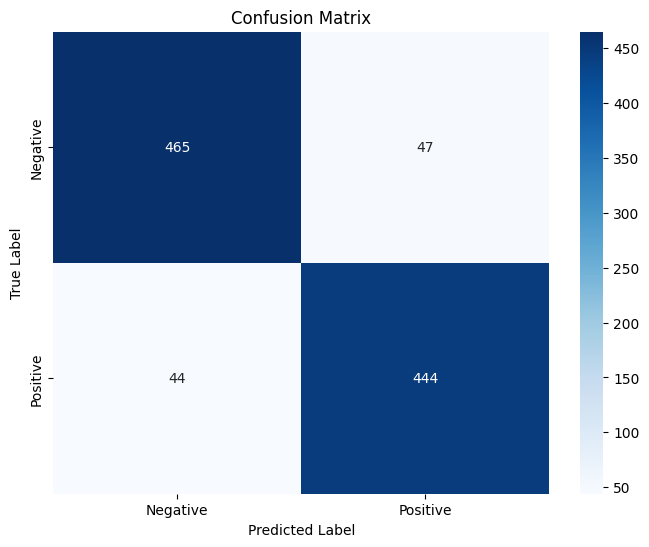

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(labels, preds, class_names=None):
    cm = confusion_matrix(labels, preds)
    
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(labels)))]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids

# Metrics
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='binary')  # Use 'macro' for multi-class
cm = confusion_matrix(labels, preds)

print("=== Model Evaluation ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nDetailed classification report:")
print(classification_report(labels, preds, target_names=['Negative', 'Positive']))

# Plot confusion matrix
plot_confusion_matrix(labels, preds, class_names=['Negative', 'Positive'])

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datasets import load_dataset
import numpy as np
from collections import Counter
import re

# Load IMDB dataset and sample
dataset = load_dataset("imdb")
train_data = dataset['train'].shuffle(seed=42).select(range(5000))
test_data = dataset['test'].shuffle(seed=42).select(range(1000))

# Simple tokenizer
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

# Build vocabulary
def build_vocab(texts, max_words):
    word_counts = Counter()
    for text in texts:
        word_counts.update(tokenize(text))
    
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, _ in word_counts.most_common(max_words - 2):
        vocab[word] = len(vocab)
    return vocab

max_words = 10000
max_len = 200
vocab = build_vocab(train_data['text'], max_words)


In [27]:
# Custom Dataset class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = tokenize(text)[:self.max_len]
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        if len(indices) < self.max_len:
            indices += [self.vocab['<pad>']] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# Prepare datasets
train_dataset = IMDBDataset(train_data['text'], train_data['label'], vocab, max_len)
test_dataset = IMDBDataset(test_data['text'], test_data['label'], vocab, max_len)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [28]:
# Define LSTM model
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout):
        super(LSTMSentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x[:, -1, :])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

# Initialize model, loss, and optimizer
devicestickersdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMSentiment(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, dropout=0.2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [29]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts).squeeze()
        predictions = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())





Epoch 1, Loss: 0.6936
Epoch 2, Loss: 0.6875
Epoch 3, Loss: 0.6633
Epoch 4, Loss: 0.6047
Epoch 5, Loss: 0.5321
LSTM Accuracy: 0.5170
LSTM F1-Score: 0.3070
LSTM Confusion Matrix:
[[410 102]
 [381 107]]


=== Model Evaluation ===
Accuracy: 0.5170
F1-score: 0.3070

Detailed classification report:
              precision    recall  f1-score   support

    Negative       0.52      0.80      0.63       512
    Positive       0.51      0.22      0.31       488

    accuracy                           0.52      1000
   macro avg       0.52      0.51      0.47      1000
weighted avg       0.52      0.52      0.47      1000



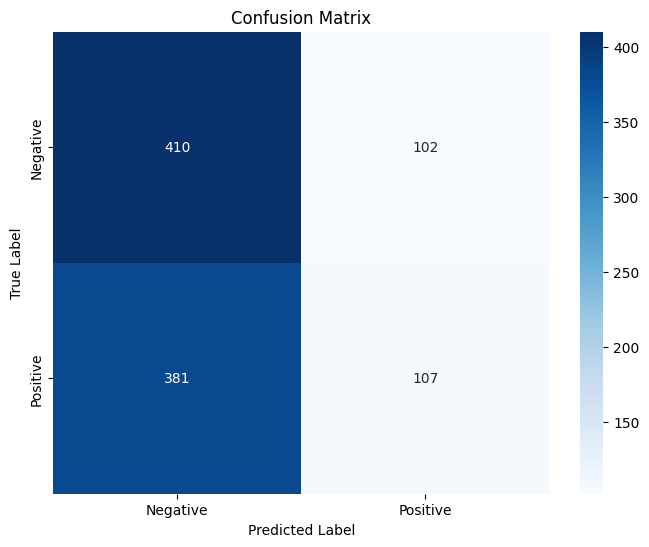

In [32]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print evaluation metrics
print("=== Model Evaluation ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names=['Negative', 'Positive'])

# Task 8

In [35]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns


In [36]:
# Load dataset and tokenizer
dataset = load_dataset("imdb")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [37]:
# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)


In [38]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [39]:
# Split dataset
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))  # Subset for faster training
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",   
    save_steps=100,           
    load_best_model_at_end=True,
)



# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)



/opt/conda/envs/classifier/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
# Train model
train_result = trainer.train()


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.641400,0.425062,0.863500,0.849856,0.883000,0.866111
200,0.316100,0.234919,0.914000,0.889098,0.946000,0.916667
300,0.258200,0.260266,0.894500,0.848806,0.960000,0.900985
400,0.181400,0.284330,0.910000,0.941810,0.874000,0.906639


In [14]:
# Evaluate model
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)

# Save model
trainer.save_model("./fine_tuned_bert")

Evaluation metrics: {'eval_loss': 0.23957428336143494, 'eval_accuracy': 0.91, 'eval_precision': 0.9466230936819172, 'eval_recall': 0.869, 'eval_f1': 0.9061522419186653, 'eval_runtime': 5.8908, 'eval_samples_per_second': 339.51, 'eval_steps_per_second': 10.695, 'epoch': 3.0}


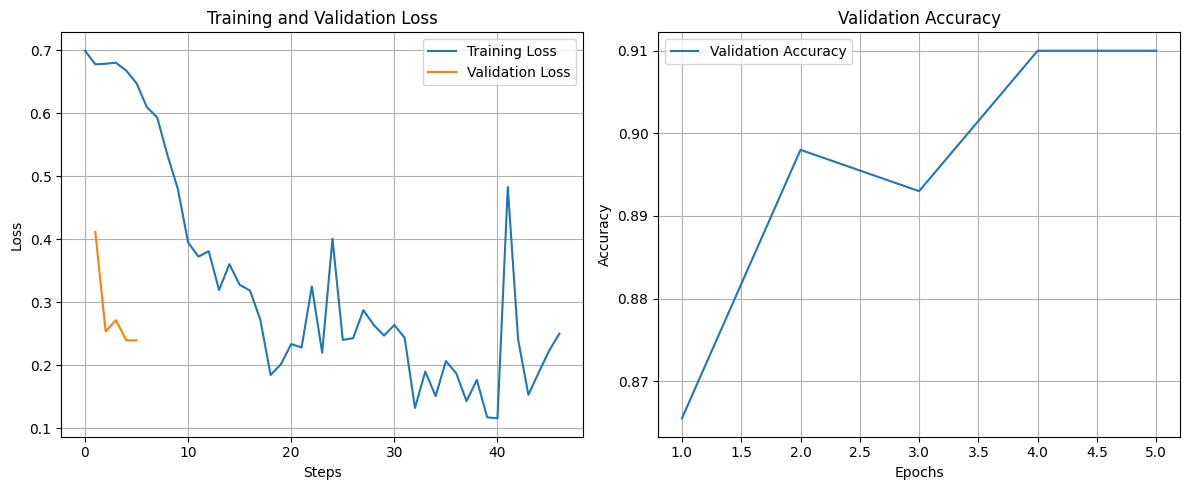

In [15]:
# Plot training curves
metrics = trainer.state.log_history
train_loss = [x["loss"] for x in metrics if "loss" in x]
eval_loss = [x["eval_loss"] for x in metrics if "eval_loss" in x]
eval_accuracy = [x["eval_accuracy"] for x in metrics if "eval_accuracy" in x]
epochs = range(1, len(eval_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.xlabel("Steps" if len(train_loss) > len(epochs) else "Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_curves.png")